In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt
from scipy.stats import poisson
from sklearn.metrics import r2_score
import matplotlib.transforms as mtransforms
from datetime import datetime, date, timedelta
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc
from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
from pandas.core import apply
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import seaborn as sns

In [2]:
datos=pd.read_excel('/content/registros_autos_entrenamiento.xlsx')
festivos = pd.read_excel('/content/festivos (2).xlsx')
navidad = pd.read_excel('/content/christmas.xlsx')
año_nuevo=pd.read_excel('/content/año_nuevo.xlsx')

In [3]:
anio=pd.DataFrame({'Fecha': pd.to_datetime(datos['Fecha'].values)})
datos['Year']=anio['Fecha'].dt.year
datos['Mes']=anio['Fecha'].dt.month
datos['Dia']=anio['Fecha'].dt.day
datos['DiaNom'] = anio['Fecha'].dt.day_name()
datos['festivos'] = np.where(datos.loc[:,'Fecha'].isin(festivos['holidays_fecha']),1,0)
datos['quincena'] = np.where(datos.loc[:,'Fecha'].dt.day.isin([15,30,31]),1,0)
#datos['navidad'] = np.where(datos.loc[:,'Fecha'].isin(navidad['christmas_fecha']),1,0)
#datos['año_nuevo'] = np.where(datos.loc[:,'Fecha'].isin(año_nuevo['primer_dia_año']),1,0)
datos

,Fecha,Unidades,Year,Mes,Dia,DiaNom,festivos,quincena
0,2012-01-01,0,2012,1,1,Sunday,0,0
1,2012-01-02,188,2012,1,2,Monday,0,0
2,2012-01-03,482,2012,1,3,Tuesday,0,0
3,2012-01-04,927,2012,1,4,Wednesday,0,0
4,2012-01-05,1159,2012,1,5,Thursday,0,0
...,...,...,...,...,...,...,...,...
2187,2017-12-27,2102,2017,12,27,Wednesday,0,0
2188,2017-12-28,3449,2017,12,28,Thursday,0,0
2189,2017-12-29,1084,2017,12,29,Friday,0,0
2190,2017-12-30,18,2017,12,30,Saturday,0,1


In [5]:
z = np.abs(stats.zscore(datos["Unidades"]))
datos["Z_CT"]=z
datos[datos["Z_CT"]>1.1]

,Fecha,Unidades,Year,Mes,Dia,DiaNom,festivos,quincena,Z_CT
0,2012-01-01,0,2012,1,1,Sunday,0,0,1.419438
7,2012-01-08,0,2012,1,8,Sunday,0,0,1.419438
8,2012-01-09,0,2012,1,9,Monday,1,0,1.419438
14,2012-01-15,1,2012,1,15,Sunday,0,1,1.417623
21,2012-01-22,0,2012,1,22,Sunday,0,0,1.419438
...,...,...,...,...,...,...,...,...,...
2185,2017-12-25,0,2017,12,25,Monday,1,0,1.419438
2187,2017-12-27,2102,2017,12,27,Wednesday,0,0,2.395174
2188,2017-12-28,3449,2017,12,28,Thursday,0,0,4.839647
2190,2017-12-30,18,2017,12,30,Saturday,0,1,1.386772


In [6]:
df=datos[datos["Z_CT"]<=1.1]

In [7]:
train = df[df["Year"] <=2016]

test = df[df["Year"] ==2017]

In [8]:
train = pd.get_dummies(train)
train

,Fecha,Unidades,Year,Mes,Dia,festivos,quincena,Z_CT,DiaNom_Friday,DiaNom_Monday,DiaNom_Saturday,DiaNom_Thursday,DiaNom_Tuesday,DiaNom_Wednesday
1,2012-01-02,188,2012,1,2,0,0,1.078264,0,1,0,0,0,0
2,2012-01-03,482,2012,1,3,0,0,0.544727,0,0,0,0,1,0
3,2012-01-04,927,2012,1,4,0,0,0.262839,0,0,0,0,0,1
4,2012-01-05,1159,2012,1,5,0,0,0.683862,0,0,0,1,0,0
5,2012-01-06,996,2012,1,6,0,0,0.388057,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1812,2016-12-17,378,2016,12,17,0,0,0.733461,0,0,1,0,0,0
1814,2016-12-19,1240,2016,12,19,0,0,0.830857,0,1,0,0,0,0
1819,2016-12-24,334,2016,12,24,0,0,0.813310,0,0,1,0,0,0
1821,2016-12-26,1234,2016,12,26,0,0,0.819968,0,1,0,0,0,0


In [9]:
test = pd.get_dummies(test)
test

,Fecha,Unidades,Year,Mes,Dia,festivos,quincena,Z_CT,DiaNom_Friday,DiaNom_Monday,DiaNom_Saturday,DiaNom_Thursday,DiaNom_Tuesday,DiaNom_Wednesday
1830,2017-01-04,232,2017,1,4,0,0,0.998415,0,0,0,0,0,1
1831,2017-01-05,455,2017,1,5,0,0,0.593725,0,0,0,1,0,0
1832,2017-01-06,776,2017,1,6,0,0,0.011189,1,0,0,0,0,0
1833,2017-01-07,192,2017,1,7,0,0,1.071005,0,0,1,0,0,0
1836,2017-01-10,609,2017,1,10,0,0,0.314253,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2178,2017-12-18,959,2017,12,18,0,0,0.320911,0,1,0,0,0,0
2179,2017-12-19,1364,2017,12,19,0,0,1.055886,0,0,0,0,1,0
2183,2017-12-23,496,2017,12,23,0,0,0.519320,0,0,1,0,0,0
2186,2017-12-26,1251,2017,12,26,0,0,0.850819,0,0,0,0,1,0


In [10]:
formula = 'Unidades~Year+Mes+Dia+festivos+quincena+DiaNom_Friday+DiaNom_Monday+DiaNom_Saturday+DiaNom_Thursday+DiaNom_Tuesday+DiaNom_Wednesday'

In [11]:
model = smf.glm(formula = formula, data=train, family=sm.families.Poisson()).fit()

In [12]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Unidades   No. Observations:                 1273
Model:                            GLM   Df Residuals:                     1263
Model Family:                 Poisson   Df Model:                            9
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -26763.
Date:                Fri, 01 Dec 2023   Deviance:                       42642.
Time:                        09:36:43   Pearson chi2:                 4.28e+04
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           93.8361      1.128     83.161      0.000      91.625      96.048
Year                -0.0511      0.001    -78.158      0.000      -0.052      -0.050
Mes                  0.0103      0.000     36.980      0.000       0.010       0.011
Dia                  0.0072      0.000     63.115      0.000       0.007       0.007
festivos          1.075e-13   1.29e-15     83.046      0.000    1.05e-13     1.1e-13
quincena             0.0352      0.004      9.122      0.000       0.028       0.043
DiaNom_Friday       15.9142      0.188     84.597      0.000      15.545      16.283
DiaNom_Monday       15.5853      0.188     82.883      0.000      15.217      15.954
DiaNom_Saturday     14.8014      0.188     78.708      0.000      14.433      15.170
DiaNom_Thursday     15.9053      0.188     84.554      0.000      15.537      16.274
DiaNom_Tuesday      15.7580      0.188     83.799      0.000      15.389      16.127
DiaNom_Wednesday    15.8719      0.188     84.391      0.000      15.503      16.241
====================================================================================
"""

In [13]:
predict_tr = model.predict(train)
predict_tes = model.predict(test)

In [14]:
mse_train = mse(train.Unidades, predict_tr)
mse_train

27449.703309090033

In [15]:
mse_test = mse(test.Unidades, predict_tes)
mse_test

25219.823949931382

In [16]:
variacion=(abs((mse_train-mse_test)/mse_train))*100
variacion

8.123509875679497

In [17]:
r2_train = r2_score(train.Unidades, predict_tr)
r2_test = r2_score(test.Unidades, predict_tes)
r2_train

0.7495633458798965

In [18]:
r2_test

0.6696661843274683

##Primer archivo plano prediccion entre 01/01/2012 y el 31/12/2016.

In [19]:
inicio = datetime(2012,1,1)
fin    = datetime(2016,12,31)

lista_fechas = [inicio + timedelta(days=d) for d in range((fin - inicio).days + 1)]


validacion = pd.DataFrame(lista_fechas, columns=['fecha'])
anio=pd.DataFrame({'fecha': pd.to_datetime(validacion['fecha'].values)})
validacion['Year']=anio['fecha'].dt.year
validacion['Mes']=anio['fecha'].dt.month
validacion['Dia']=anio['fecha'].dt.day
validacion['DiaNom'] = anio['fecha'].dt.day_name()
validacion['festivos'] = np.where(validacion.loc[:,'fecha'].isin(festivos['holidays_fecha']),1,0)
validacion['quincena'] = np.where(validacion.loc[:,'fecha'].dt.day.isin([15,30,31]),1,0)

In [20]:
validacion

,fecha,Year,Mes,Dia,DiaNom,festivos,quincena
0,2012-01-01,2012,1,1,Sunday,0,0
1,2012-01-02,2012,1,2,Monday,0,0
2,2012-01-03,2012,1,3,Tuesday,0,0
3,2012-01-04,2012,1,4,Wednesday,0,0
4,2012-01-05,2012,1,5,Thursday,0,0
...,...,...,...,...,...,...,...
1822,2016-12-27,2016,12,27,Tuesday,0,0
1823,2016-12-28,2016,12,28,Wednesday,0,0
1824,2016-12-29,2016,12,29,Thursday,0,0
1825,2016-12-30,2016,12,30,Friday,0,1


In [21]:
validacion =pd.get_dummies(validacion)
validacion

,fecha,Year,Mes,Dia,festivos,quincena,DiaNom_Friday,DiaNom_Monday,DiaNom_Saturday,DiaNom_Sunday,DiaNom_Thursday,DiaNom_Tuesday,DiaNom_Wednesday
0,2012-01-01,2012,1,1,0,0,0,0,0,1,0,0,0
1,2012-01-02,2012,1,2,0,0,0,1,0,0,0,0,0
2,2012-01-03,2012,1,3,0,0,0,0,0,0,0,1,0
3,2012-01-04,2012,1,4,0,0,0,0,0,0,0,0,1
4,2012-01-05,2012,1,5,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1822,2016-12-27,2016,12,27,0,0,0,0,0,0,0,1,0
1823,2016-12-28,2016,12,28,0,0,0,0,0,0,0,0,1
1824,2016-12-29,2016,12,29,0,0,0,0,0,0,1,0,0
1825,2016-12-30,2016,12,30,0,1,1,0,0,0,0,0,0


In [22]:
validacion["prediccion"] = model.predict(validacion)

In [23]:
validacion

,fecha,Year,Mes,Dia,festivos,quincena,DiaNom_Friday,DiaNom_Monday,DiaNom_Saturday,DiaNom_Sunday,DiaNom_Thursday,DiaNom_Tuesday,DiaNom_Wednesday,prediccion
0,2012-01-01,2012,1,1,0,0,0,0,0,1,0,0,0,0.000132
1,2012-01-02,2012,1,2,0,0,0,1,0,0,0,0,0,780.113885
2,2012-01-03,2012,1,3,0,0,0,0,0,0,0,1,0,933.848857
3,2012-01-04,2012,1,4,0,0,0,0,0,0,0,0,1,1054.065200
4,2012-01-05,2012,1,5,0,0,0,0,0,0,1,0,0,1097.697071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1822,2016-12-27,2016,12,27,0,0,0,0,0,0,0,1,0,1012.749244
1823,2016-12-28,2016,12,28,0,0,0,0,0,0,0,0,1,1143.122601
1824,2016-12-29,2016,12,29,0,0,0,0,0,0,1,0,0,1190.440905
1825,2016-12-30,2016,12,30,0,1,1,0,0,0,0,0,0,1253.061969


In [24]:
validacion.head(20)

,fecha,Year,Mes,Dia,festivos,quincena,DiaNom_Friday,DiaNom_Monday,DiaNom_Saturday,DiaNom_Sunday,DiaNom_Thursday,DiaNom_Tuesday,DiaNom_Wednesday,prediccion
0,2012-01-01,2012,1,1,0,0,0,0,0,1,0,0,0,0.000132
1,2012-01-02,2012,1,2,0,0,0,1,0,0,0,0,0,780.113885
2,2012-01-03,2012,1,3,0,0,0,0,0,0,0,1,0,933.848857
3,2012-01-04,2012,1,4,0,0,0,0,0,0,0,0,1,1054.065200
4,2012-01-05,2012,1,5,0,0,0,0,0,0,1,0,0,1097.697071
5,2012-01-06,2012,1,6,0,0,1,0,0,0,0,0,0,1115.454644
6,2012-01-07,2012,1,7,0,0,0,0,1,0,0,0,0,369.217391
7,2012-01-08,2012,1,8,0,0,0,0,0,1,0,0,0,0.000139
8,2012-01-09,2012,1,9,1,0,0,1,0,0,0,0,0,820.311287
9,2012-01-10,2012,1,10,0,0,0,0,0,0,0,1,0,981.967855


In [25]:
dt=(datos['Fecha']>='2012-01-01')&(datos['Fecha']<='2016-12-31')
dt

0        True
1        True
2        True
3        True
4        True
        ...  
2187    False
2188    False
2189    False
2190    False
2191    False
Name: Fecha, Length: 2192, dtype: bool

In [26]:
dt1=datos[dt]
dt1

,Fecha,Unidades,Year,Mes,Dia,DiaNom,festivos,quincena,Z_CT
0,2012-01-01,0,2012,1,1,Sunday,0,0,1.419438
1,2012-01-02,188,2012,1,2,Monday,0,0,1.078264
2,2012-01-03,482,2012,1,3,Tuesday,0,0,0.544727
3,2012-01-04,927,2012,1,4,Wednesday,0,0,0.262839
4,2012-01-05,1159,2012,1,5,Thursday,0,0,0.683862
...,...,...,...,...,...,...,...,...,...
1822,2016-12-27,1922,2016,12,27,Tuesday,0,0,2.068519
1823,2016-12-28,2409,2016,12,28,Wednesday,0,0,2.952304
1824,2016-12-29,3603,2016,12,29,Thursday,0,0,5.119119
1825,2016-12-30,965,2016,12,30,Friday,0,1,0.331799


In [27]:
y_true = dt1['Unidades']
y_pred = model.predict(validacion)

In [28]:
y_true

0          0
1        188
2        482
3        927
4       1159
        ... 
1822    1922
1823    2409
1824    3603
1825     965
1826      46
Name: Unidades, Length: 1827, dtype: int64

In [29]:
y_pred

0          0.000132
1        780.113885
2        933.848857
3       1054.065200
4       1097.697071
           ...     
1822    1012.749244
1823    1143.122601
1824    1190.440905
1825    1253.061969
1826     414.765651
Length: 1827, dtype: float64

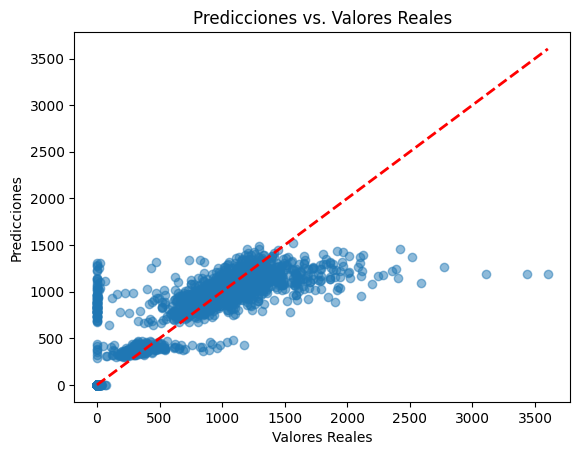

In [30]:
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--', linewidth=2)
plt.title('Predicciones vs. Valores Reales')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.show()

In [31]:
mae = mean_absolute_error(y_true, y_pred)
mse = mse(y_true, y_pred)
rmse = np.sqrt(mse)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

Mean Absolute Error (MAE): 185.12094299276612
Mean Squared Error (MSE): 99089.34014117518
Root Mean Squared Error (RMSE): 314.78459323984583


In [32]:
r2 = r2_score(y_true, y_pred)
r2

0.6748219507729569

In [33]:
validacion['fecha_index'] = validacion['fecha']
validacion['fecha_index2'] = validacion['fecha']

In [34]:
def prediccion(fecha_inicial, fecha_final, df):
  inicio = datetime.strptime(fecha_inicial, '%Y/%m/%d')
  fin = datetime.strptime(fecha_final, '%Y/%m/%d')

  mask = (datos['fecha'] >= inicio) & (df['fecha'] <= fin)

  registros = datos.loc[mask]['prediccion'].sum()

  return registros

In [35]:
prediccion_2012_2016=validacion[['fecha','prediccion']]
prediccion_2012_2016

,fecha,prediccion
0,2012-01-01,0.000132
1,2012-01-02,780.113885
2,2012-01-03,933.848857
3,2012-01-04,1054.065200
4,2012-01-05,1097.697071
...,...,...
1822,2016-12-27,1012.749244
1823,2016-12-28,1143.122601
1824,2016-12-29,1190.440905
1825,2016-12-30,1253.061969


In [36]:
prediccion_2012_2016.to_excel('prediccion_2012_2016.xlsx', encoding = 'utf-8', index = False)

/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py:211: FutureWarning: the 'encoding' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'encoding'
  return func(*args, **kwargs)


##Segundo archivo plano prediccion primer semestre 2018

In [37]:
inicio1 = datetime(2018,1,1)
fin1    = datetime(2018,6,30)

lista_fechas = [inicio1 + timedelta(days=d) for d in range((fin1 - inicio1).days + 1)]


validacion = pd.DataFrame(lista_fechas, columns=['fecha'])
anio=pd.DataFrame({'fecha': pd.to_datetime(validacion['fecha'].values)})
validacion['Year']=anio['fecha'].dt.year
validacion['Mes']=anio['fecha'].dt.month
validacion['Dia']=anio['fecha'].dt.day
validacion['DiaNom'] = anio['fecha'].dt.day_name()
validacion['festivos'] = np.where(validacion.loc[:,'fecha'].isin(festivos['holidays_fecha']),1,0)
validacion['quincena'] = np.where(validacion.loc[:,'fecha'].dt.day.isin([15,30,31]),1,0)

In [38]:
validacion =pd.get_dummies(validacion)
validacion.head(20)

,fecha,Year,Mes,Dia,festivos,quincena,DiaNom_Friday,DiaNom_Monday,DiaNom_Saturday,DiaNom_Sunday,DiaNom_Thursday,DiaNom_Tuesday,DiaNom_Wednesday
0,2018-01-01,2018,1,1,1,0,0,1,0,0,0,0,0
1,2018-01-02,2018,1,2,0,0,0,0,0,0,0,1,0
2,2018-01-03,2018,1,3,0,0,0,0,0,0,0,0,1
3,2018-01-04,2018,1,4,0,0,0,0,0,0,1,0,0
4,2018-01-05,2018,1,5,0,0,1,0,0,0,0,0,0
5,2018-01-06,2018,1,6,0,0,0,0,1,0,0,0,0
6,2018-01-07,2018,1,7,0,0,0,0,0,1,0,0,0
7,2018-01-08,2018,1,8,1,0,0,1,0,0,0,0,0
8,2018-01-09,2018,1,9,0,0,0,0,0,0,0,1,0
9,2018-01-10,2018,1,10,0,0,0,0,0,0,0,0,1


In [39]:
validacion["prediccion"] = model.predict(validacion)

In [40]:
validacion

,fecha,Year,Mes,Dia,festivos,quincena,DiaNom_Friday,DiaNom_Monday,DiaNom_Saturday,DiaNom_Sunday,DiaNom_Thursday,DiaNom_Tuesday,DiaNom_Wednesday,prediccion
0,2018-01-01,2018,1,1,1,0,0,1,0,0,0,0,0,570.059994
1,2018-01-02,2018,1,2,0,0,0,0,0,0,0,1,0,682.400203
2,2018-01-03,2018,1,3,0,0,0,0,0,0,0,0,1,770.247028
3,2018-01-04,2018,1,4,0,0,0,0,0,0,1,0,0,802.130557
4,2018-01-05,2018,1,5,0,0,1,0,0,0,0,0,0,815.106717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,2018-06-26,2018,6,26,0,0,0,0,0,0,0,1,0,853.488403
177,2018-06-27,2018,6,27,0,0,0,0,0,0,0,0,1,963.359774
178,2018-06-28,2018,6,28,0,0,0,0,0,0,1,0,0,1003.236993
179,2018-06-29,2018,6,29,0,0,1,0,0,0,0,0,0,1019.466475


In [41]:
prediccion_01_2018=validacion[['fecha','prediccion']]
prediccion_01_2018

,fecha,prediccion
0,2018-01-01,570.059994
1,2018-01-02,682.400203
2,2018-01-03,770.247028
3,2018-01-04,802.130557
4,2018-01-05,815.106717
...,...,...
176,2018-06-26,853.488403
177,2018-06-27,963.359774
178,2018-06-28,1003.236993
179,2018-06-29,1019.466475


In [42]:
prediccion_01_2018.to_excel('prediccion_01_2018.xlsx', encoding = 'utf-8', index = False)

/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py:211: FutureWarning: the 'encoding' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'encoding'
  return func(*args, **kwargs)
